In [2]:
# The code was removed by Watson Studio for sharing.

(8359, 2)


,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


## Data Source

U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED,  
Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILBRENTEU, June 12, 2019.

In [3]:
# Clean the data set to remove missing values
df_data_1 = df_data_1[df_data_1.DCOILBRENTEU != "."]
print(df_data_1.shape)

(8131, 2)


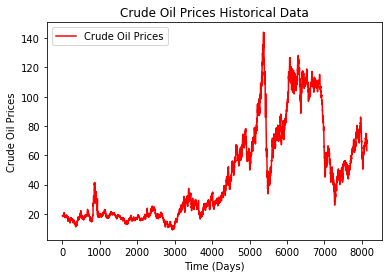

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
df_data_1_plot = df_data_1.iloc[:,1:2].values.astype(float)
# Visualising the Data
plt.plot(df_data_1_plot, color = 'red', label = 'Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

## Stateful vs. Stateless LSTM

1. **Stateless**: LSTM updates parameters on **batch 1** and then initiates cell states (meaning - memory, usually with zeros) for batch 2
2. **Stateful**: it uses batch 1 last output cell sates as initial states for **batch 2**.

## When to use which?

* When sequences in batches are related to each other (e.g. prices of one commodity), we should better use **stateful** mode
* Else, when one sequence represents a complete sentence, we should go with **stateless** mode

## Batch-size: which batch-size to choose?
#### Very important decision!

Imagine, you must learn to recognize a bird... You are presented images of different birds.

What would you prefer:

1. To see the one image at a time, make your notes about special bird quilities (set your weights) and then see another bird and so on
2. **OR** may be you would better learn if you see - let's say 5 - bird images at ones. May be then you can faster notice the bird's intrinsic properties?

I'd say - the second method is more efficient for humans. We need more examples of an entitiy, that we have to distinguish.

**So the machines! Therefore we select a batch size of 64. Later in programming assigment we will see how the batch size impacts the prediction accuracy.**

In [6]:
#import packages
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import load_model

Using TensorFlow backend.


In [7]:
# defining the batch size and number of epochs
batch_size = 64
epochs = 120
timesteps = 30 #how far back in time to look to predict the same amount of steps in the future.  in this data 1 time step is 1 day

## Batch-size and trainings-set size

With **stateful LSTMs** the trainings-set size must be divisible without remainder by the batch-size (modulo = 0)

In [8]:
length = len(df_data_1)
print(length)
length *= 1 - 0.1
print(length)

8131
7317.900000000001


In [9]:
7004.7%64.0

28.699999999999818

In [10]:
6976.0%64.0

0.0

In [22]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
    return (max(train_length_values))

In [23]:
length = get_train_length(df_data_1, batch_size, 0.1)
print(length)

7296


In [24]:
#Adding timesteps * 2
upper_train = length + timesteps*2
df_data_1_train = df_data_1[0:upper_train]
training_set = df_data_1_train.iloc[:,1:2].values
training_set.shape

(7356, 1)

In [25]:
# Feature Scaling
#scale between 0 and 1. the weights are esier to find.
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(7356, 1)

In [ ]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print(length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print(len(X_train))
print(len(y_train))

In [26]:
#create X_train matrix
#30 items per array (timestep) 
print(X_train[0:2])
print(np.array(X_train).shape)
#create Y_train matrix
#30 items per array (timestep) 
print(y_train[0:2])
print(np.array(y_train).shape)

7326
7296
7296
[array([ 0.07067112,  0.0693363 ,  0.07007786,  0.07044865,  0.07067112,
        0.07044865,  0.07044865,  0.07030033,  0.07081943,  0.0710419 ,
        0.07156099,  0.07178346,  0.07081943,  0.07156099,  0.07178346,
        0.07178346,  0.0710419 ,  0.07178346,  0.07267334,  0.07363737,
        0.07378569,  0.07378569,  0.07415647,  0.07267334,  0.07156099,
        0.07119021,  0.07400816,  0.07452725,  0.07400816,  0.07326659]), array([ 0.0693363 ,  0.07007786,  0.07044865,  0.07067112,  0.07044865,
        0.07044865,  0.07030033,  0.07081943,  0.0710419 ,  0.07156099,
        0.07178346,  0.07081943,  0.07156099,  0.07178346,  0.07178346,
        0.0710419 ,  0.07178346,  0.07267334,  0.07363737,  0.07378569,
        0.07378569,  0.07415647,  0.07267334,  0.07156099,  0.07119021,
        0.07400816,  0.07452725,  0.07400816,  0.07326659,  0.07526882])]
(7296, 30)
[array([ 0.07526882,  0.07586207,  0.07697442,  0.07712273,  0.07697442,
        0.07845755,  0.07882833,

In [27]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(7296, 30, 1)
(7296, 30, 1)


In [28]:
# Building the LSTM
# Importing the Keras libraries and packages

from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

In [43]:
from tensorflow.python.ops import control_flow_ops

orig_while_loop = control_flow_ops.while_loop

def patched_while_loop(*args, **kwargs):
    kwargs.pop("maximum_iterations", None)  # Ignore.
    return orig_while_loop(*args, **kwargs)


control_flow_ops.while_loop = patched_while_loop

In [44]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
#each layer is the input of the next layer
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

#adam is fast starting off and then gets slower and more precise
#mae -> mean absolute error loss function
regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_5 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_6 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_1 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


## How LSTM Param Number is computed?

1. To decide how to handle the memory each LSTM Cell has :
    * input (what to let in),
    * forget (what to forget) and
    * output (what to write to the output)
2. LSTM Cell State is its memory
3. LSTM Hidden State is equivalent to the Cell output:
    * lstm_hidden_state_size (number of neurons = memory cells) = lstm_outputs_size
4. Parameters:
    * weights for the inputs (lstm_inputs_size)
    * weights for the outputs (lstm_outputs_size)
    * bias variable
5. Result from previous point - for all 3 Gates and for Cell State ( = 4)

\begin{equation*}
\textbf{PARAMETERS} = \textbf4 \times \textbf{ LSTM outputs size} \times (\textbf{weights LSTM inputs size} + \textbf{weights LSTM outputs size} + 1 \textbf{ bias variable})
\end{equation*}

In [45]:
# 1st LSTM Layer
parameters = 4 * 10 * (1 + 10 + 1)
print(parameters)

480


In [46]:
parameters = 4 * 10 * (10 + 10 + 1)
print(parameters)

840


In [47]:
#Statefull
for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    #resets only the states but the weights, cell and hidden are kept.
    regressor_mae.reset_states()
    
#Stateless
#between the batches the cell and hidden states are lost.
#regressor_mae.fit(X_train, y_train, shuffle=False, epochs = epochs, batch_size = batch_size)

Epoch: 0
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/envs/DSX-Python35/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/envs/DSX-Python35/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start\n    self.io_loop.start()', 'File "/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/tornado/ioloop.py", line 888,

In [48]:
#save model
import h5py
regressor_mae.save(filepath="my_model_with_mae_30_ts.h5")

In [49]:
#load model
import h5py
regressor_mae = load_model(filepath="my_model_with_mae_30_ts.h5")

In [54]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [55]:
test_length = get_test_length(df_data_1, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

7932
7996
8060
8060
704


In [56]:
# construct test set

#subsetting
df_data_1_test = df_data_1[upper_train:upper_test] 
test_set = df_data_1_test.iloc[:,1:2].values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [58]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(704, 30, 1)
(704, 30)
(674, 1)


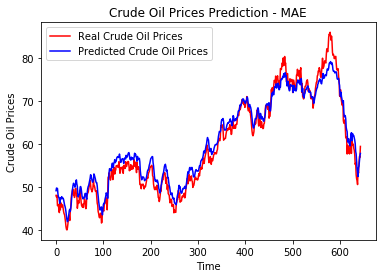

In [59]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)].astype(float), color = 'red', label = 'Real Crude Oil Prices')
plt.plot(y_test[0:len(y_test) - timesteps].astype(float), color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()